Attention visualization

In [1]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torchvision import transforms
import torch
import torch.nn as nn
from copy import deepcopy
import sys
from models.layers import Identity
import types
import sys
import models.models_vit as mae

from models.layers import Identity, DinoVisionTransformerClassifier
from models.unsupervised import imagenet_mae_base_pretrained, imagenet_resnet50_dino
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet50
from torchcam.methods import SmoothGradCAMpp
import torch 


In [2]:
class Identity(nn.Module):
    """An identity layer"""
    def __init__(self, d):
        super().__init__()
        self.in_features = d
        self.out_features = d

    def forward(self, x):
        return x

class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self, d_out = 10, model_name = 'dinov2_vits14'):
        super(DinoVisionTransformerClassifier, self).__init__()
        checkpoint_model = torch.hub.load('facebookresearch/dinov2', model_name)
        self.transformer = deepcopy(checkpoint_model)
        self.classifier = nn.Linear(384, d_out)

    def forward(self, x):
        x = self.transformer(x)
        #x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

In [3]:
def _replace_fc(model, output_dim):
    d = model.fc.in_features
    model.fc = torch.nn.Linear(d, output_dim)
    return model

def _vit_replace_fc(model, output_dim):
    model.fc = torch.nn.Identity()
    model.fc.in_features = model.head.in_features
    delattr(model, "head")

    def forward(self, x):
        x = self.forward_features(x)
        x = self.fc(x)
        return x

    forwardType = types.MethodType
    model.forward = forwardType(forward, model)
    return _replace_fc(model, output_dim)

def imagenet_resnet50_dino(output_dim):
    # workaround to avoid module name collision
    #sys.modules.pop("utils")
    model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
    model.fc.in_features = 2048
    return _replace_fc(model, output_dim)

def load_mae_model(model, checkpoint_path, global_pool=True):
    from timm.models.layers import trunc_normal_
    from models.util.pos_embed import interpolate_pos_embed

    checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
    print("Load pre-trained checkpoint from: %s" % checkpoint_path)
    if 'model' in checkpoint:
        checkpoint_model = checkpoint['model']
    else:
        checkpoint_model = checkpoint

    for k in ['head.weight', 'head.bias']:
        if k in checkpoint_model:# and checkpoint_model[k].shape != state_dict[k].shape:
            print(f"Removing key {k} from pretrained checkpoint")
            del checkpoint_model[k]

    if global_pool:
        for k in ['fc_norm.weight', 'fc_norm.bias']:
            if k in checkpoint_model:
                print(f"Removing key {k} from pretrained checkpoint")
                del checkpoint_model[k]

    # interpolate position embedding
    interpolate_pos_embed(model, checkpoint_model)

    # load pre-trained model
    msg = model.load_state_dict(checkpoint_model, strict=False)
    print(msg)

    trunc_normal_(model.head.weight, std=2e-5)

def imagenet_mae_base_pretrained(output_dim):
    model = mae.vit_base_patch16(num_classes=output_dim)
    load_mae_model(model, '/kaggle/input/mae-checkpoint/mae_pretrain_vit_base.pth')
    return _vit_replace_fc(model, output_dim)


/Users/juniorcedrictonga/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def initialize_model(config, d_out, is_featurizer=False):
    """
    Initializes models according to the config
        Args:
            - config (dictionary): config dictionary
            - d_out (int): the dimensionality of the model output
            - is_featurizer (bool): whether to return a model or a (featurizer, classifier) pair that constitutes a model.
        Output:
            If is_featurizer=True:
            - featurizer: a model that outputs feature Tensors of shape (batch_size, ..., feature dimensionality)
            - classifier: a model that takes in feature Tensors and outputs predictions. In most cases, this is a linear layer.

            If is_featurizer=False:
            - model: a model that is equivalent to nn.Sequential(featurizer, classifier)

        Pretrained weights are loaded according to config.pretrained_model_path using either transformers.from_pretrained (for bert-based models)
        or our own utils.load function (for torchvision models, resnet18-ms, and gin-virtual).
        There is currently no support for loading pretrained weights from disk for other models.
    """
    # If load_featurizer_only is True,
    # then split into (featurizer, classifier) for the purposes of loading only the featurizer,
    # before recombining them at the end
    featurize = is_featurizer or config.load_featurizer_only or (config.local_norm == 'last')

    if config.model == 'resnet50':
        if featurize:
            featurizer = initialize_torchvision_model(
                name=config.model,
                d_out=None,
                **config.model_kwargs)
            classifier = nn.Linear(featurizer.d_out, d_out)
            model = (featurizer, classifier)
        else:
            model = initialize_torchvision_model(
                name=config.model,
                d_out=d_out,
                **config.model_kwargs)
            
    elif config.model == 'dino':
        if featurize:
            # Initialize DINO model without final classification layer
            featurizer = imagenet_resnet50_dino(None)
            # Create a linear classifier with the output dimension of the featurizer
            classifier = nn.Linear(featurizer.fc.in_features, d_out)
            model = (featurizer, classifier)
        else:
            # Initialize DINO model with final classification layer for the specified output dimension
            model = imagenet_resnet50_dino(d_out)
    
    elif config.model == 'dinov2':
        if featurize:
            # Initialize DINO model without final classification layer
            featurizer = DinoVisionTransformerClassifier(d_out = None, model_name = 'dinov2_vits14')
            # Create a linear classifier with the output dimension of the featurizer
            classifier = nn.Linear(featurizer.fc.in_features, d_out)
            print('featurizer')
            model = (featurizer, classifier)
        else:
            # Initialize DINO model with final classification layer for the specified output dimension
            model = DinoVisionTransformerClassifier(d_out=d_out, model_name = 'dinov2_vits14')

    elif config.model== 'mae':
        if featurize:
            # Initialize DINO model without final classification layer
            featurizer = imagenet_mae_base_pretrained(d_out = None)
            # Create a linear classifier with the output dimension of the featurizer
            classifier = nn.Linear(featurizer.fc.in_features, d_out)
            model = (featurizer, classifier)
        else:
            # Initialize DINO model with final classification layer for the specified output dimension
            model = imagenet_mae_base_pretrained(d_out)

            
    elif 'bert' in config.model:
        if featurize:
            featurizer = initialize_bert_based_model(config, d_out, featurize)
            classifier = nn.Linear(featurizer.d_out, d_out)
            model = (featurizer, classifier)
        else:
            model = initialize_bert_based_model(config, d_out)

    else:
        raise ValueError(f'Model: {config.model} not recognized.')

    # Recombine model if we originally split it up just for loading
    if featurize and not is_featurizer:
        model = nn.Sequential(*model)

    # The `needs_y` attribute specifies whether the model's forward function
    # needs to take in both (x, y).
    # If False, Algorithm.process_batch will call model(x).
    # If True, Algorithm.process_batch() will call model(x, y) during training,
    # and model(x, None) during eval.
    if not hasattr(model, 'needs_y'):
        # Sometimes model is a tuple of (featurizer, classifier)
        if is_featurizer:
            for submodel in model:
                submodel.needs_y = False
        else:
            model.needs_y = False

    return model


def initialize_bert_based_model(config, d_out, featurize=False):
    from models.bert.bert import BertClassifier, BertFeaturizer
    from models.bert.distilbert import DistilBertClassifier, DistilBertFeaturizer

    if config.pretrained_model_path:
        print(f'Initialized model with pretrained weights from {config.pretrained_model_path}')
        config.model_kwargs['state_dict'] = torch.load(config.pretrained_model_path, map_location=config.device)

    if config.model == 'bert-base-uncased':
        if featurize:
            model = BertFeaturizer.from_pretrained(config.model, **config.model_kwargs)
        else:
            model = BertClassifier.from_pretrained(
                config.model,
                num_labels=d_out,
                **config.model_kwargs)
    elif config.model == 'distilbert-base-uncased':
        if featurize:
            model = DistilBertFeaturizer.from_pretrained(config.model, **config.model_kwargs)
        else:
            model = DistilBertClassifier.from_pretrained(
                config.model,
                num_labels=d_out,
                **config.model_kwargs)
    else:
        raise ValueError(f'Model: {config.model} not recognized.')
    return model

def initialize_torchvision_model(name, d_out, **kwargs):
    import torchvision

    # get constructor and last layer names
    if name == 'resnet50':
        constructor_name = name
        last_layer_name = 'fc'
    else:
        raise ValueError(f'Torchvision model {name} not recognized')
    # construct the default model, which has the default last layer
    constructor = getattr(torchvision.models, constructor_name)
    model = constructor(**kwargs)
    # adjust the last layer
    d_features = getattr(model, last_layer_name).in_features
    if d_out is None:  # want to initialize a featurizer model
        last_layer = Identity(d_features)
        model.d_out = d_features
    else: # want to initialize a classifier for a particular num_classes
        last_layer = nn.Linear(d_features, d_out)
        model.d_out = d_out
    setattr(model, last_layer_name, last_layer)

    return model

In [5]:
model=imagenet_resnet50_dino(output_dim=2)

state_dict= torch.load('/Users/juniorcedrictonga/Documents/Object detection and computer vision/test22/test_3-/models/waterbirds_seed_0_epoch_best_model.pth',map_location=torch.device('cpu'))


new_state_dict = {}
for key, value in state_dict['algorithm'].items():
    new_key = key.replace("model.", "")  # Retirer le préfixe "model."
    new_state_dict[new_key] = value

model.load_state_dict(new_state_dict)

print(model)


Using cache found in /Users/juniorcedrictonga/.cache/torch/hub/facebookresearch_dino_main
/Users/juniorcedrictonga/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/juniorcedrictonga/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
model.layer4[-1]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [7]:
model2=imagenet_resnet50_dino(output_dim=2)
state_dict= torch.load('/Users/juniorcedrictonga/Documents/Object detection and computer vision/test22/test_3-/models/waterbirds_seed_0_epoch_best_model.pth',map_location=torch.device('cpu'))
#model.load_state_dict(state_dict['algorithm'])

new_state_dict = {}
for key, value in state_dict['algorithm'].items():
    new_key = key.replace("model.", "")  # Retirer le préfixe "model."
    new_state_dict[new_key] = value

model.load_state_dict(new_state_dict)

print(model)

Using cache found in /Users/juniorcedrictonga/.cache/torch/hub/facebookresearch_dino_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
model3=DinoVisionTransformerClassifier(d_out=2, model_name = 'dinov2_vits14')
state_dict= torch.load('/Users/juniorcedrictonga/Documents/Object detection and computer vision/test22/test_3-/models/waterbirds_seed_0_epoch_best_model-2.pth',map_location=torch.device('cpu'))
#model.load_state_dict(state_dict['algorithm'])

new_state_dict = {}
for key, value in state_dict['algorithm'].items():
    new_key = key.replace("model.", "")  # Retirer le préfixe "model."
    new_state_dict[new_key] = value

model3.load_state_dict(new_state_dict)

print(model3)

Using cache found in /Users/juniorcedrictonga/.cache/torch/hub/facebookresearch_dinov2_main
/Users/juniorcedrictonga/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/juniorcedrictonga/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/juniorcedrictonga/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformerClassifier(
  (transformer): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, in

In [10]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
import numpy as np
import cv2
from PIL import Image

In [79]:
model.eval()
target_layers_1 = [model.layer4[-1]]
image = Image.open('/Users/juniorcedrictonga/Documents/Object detection and computer vision/test22/test_3-/Laysan_Albatross_0021_737.jpg')

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_np = np.array(image).astype(np.float32) / 255.0
# Appliquer la transformation à l'image
input_tensor_1 = preprocess(image).unsqueeze(0) 

print(input_tensor_1.shape)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...
cam = GradCAM(model=model, target_layers=target_layers_1)
# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
#rgb_img=
targets =[ClassifierOutputTarget(1)]  # Utilisez l'indice correspondant à la classe positive


# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor_1, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
#model_outputs = cam.outputs
#visualization

torch.Size([1, 3, 385, 500])


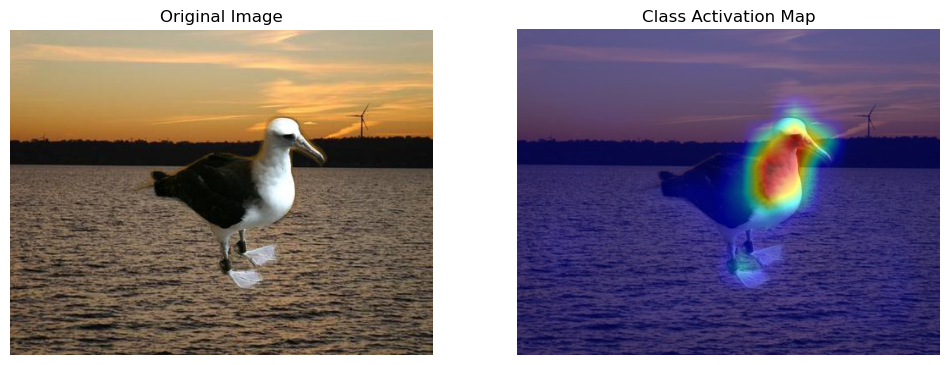

In [80]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
ax[0].imshow(img_np)
ax[0].axis('off')
ax[0].set_title('Original Image')

# Display the class activation map visualization
ax[1].imshow(visualization)
ax[1].axis('off')
ax[1].set_title('Class Activation Map')

# Show the plot
plt.show()

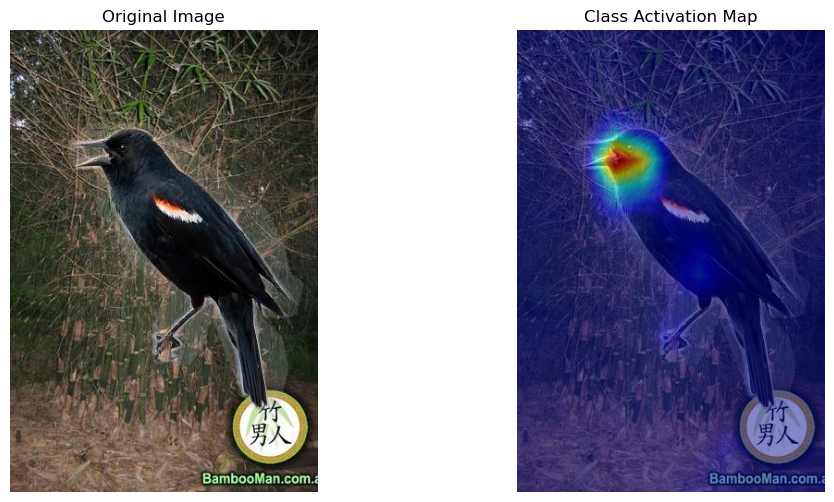

In [72]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
ax[0].imshow(img_np)
ax[0].axis('off')
ax[0].set_title('Original Image')

# Display the class activation map visualization
ax[1].imshow(visualization)
ax[1].axis('off')
ax[1].set_title('Class Activation Map')

# Show the plot
plt.show()

In [11]:
model3.transformer.blocks[-1].norm1

LayerNorm((384,), eps=1e-06, elementwise_affine=True)

In [12]:
def reshape_transform_vit_huggingface(x):
    # Remove the CLS token:
    activations = x[:, 1:, :]
    # Reshape to a 12 x 12 spatial image:
    activations = activations.view(activations.shape[0], 16, 16, 384)
    # Transpose the features to be in the second coordinate:
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

In [60]:
rgb_img = cv2.imread('/Users/juniorcedrictonga/Documents/Object detection and computer vision/test22/test_3-/Red_Winged_Blackbird_0014_3761.jpg')
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor_3 = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
print(input_tensor_3.shape)

torch.Size([1, 3, 224, 224])


In [63]:
model3.eval()
target_layers = [ model3.transformer.blocks[-1].norm1]
image = Image.open('/Users/juniorcedrictonga/Documents/Object detection and computer vision/test22/test_3-/Red_Winged_Blackbird_0014_3761.jpg')

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_np = np.array(image).astype(np.float32) / 255.0
# Appliquer la transformation à l'image
input_tensor = preprocess(image).unsqueeze(0) 

print(input_tensor.shape)


# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...
cam = GradCAM(model=model3, target_layers=target_layers, reshape_transform=reshape_transform_vit_huggingface)
# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
#rgb_img=
targets =[ClassifierOutputTarget(0)]  # Utilisez l'indice correspondant à la classe positive


# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor_3, targets=targets)

output_dimensions = cam.outputs.size()
print(output_dimensions)
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
#model_outputs = cam.outputs
#visualization

torch.Size([1, 3, 224, 224])
torch.Size([1, 2])


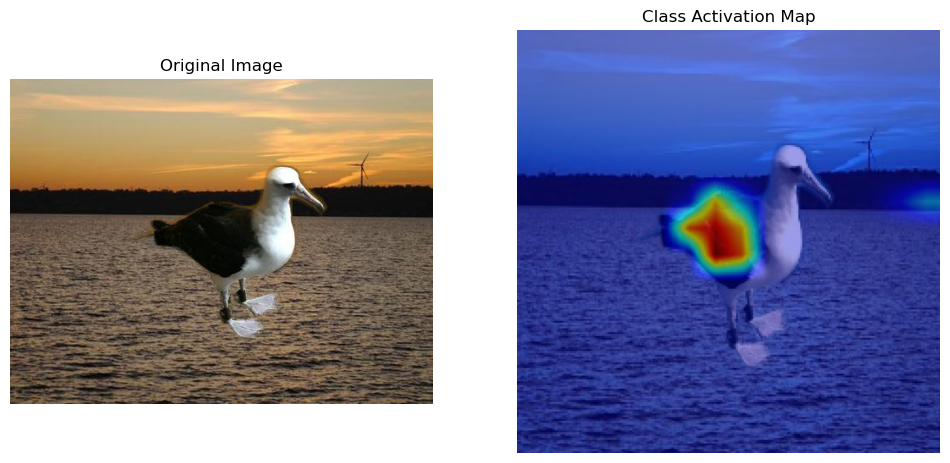

In [59]:
import matplotlib.pyplot as plt

# ...

# Show the class activation map on the image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display the original image and the visualization side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title('Original Image')

# Display the class activation map visualization
ax[1].imshow(visualization)
ax[1].axis('off')
ax[1].set_title('Class Activation Map')

# Show the plot
plt.show()


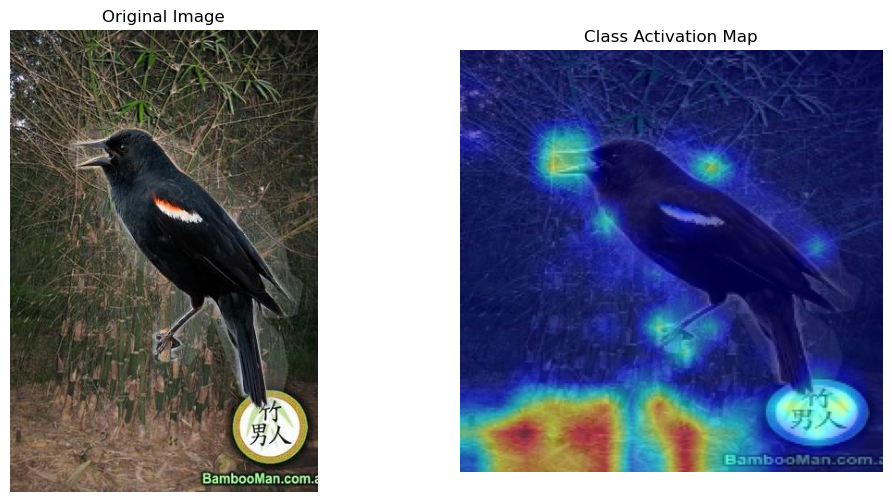

In [64]:
import matplotlib.pyplot as plt

# ...

# Show the class activation map on the image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display the original image and the visualization side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
ax[0].imshow(img_np)
ax[0].axis('off')
ax[0].set_title('Original Image')

# Display the class activation map visualization
ax[1].imshow(visualization)
ax[1].axis('off')
ax[1].set_title('Class Activation Map')

# Show the plot
plt.show()


In [ ]:
#print(model )
#model = resnet50(pretrained=True).eval()
# Get your input
imag = read_image('/Users/juniorcedrictonga/Documents/Object detection and computer vision/test22/test_3-/Red_Winged_Blackbird_0014_3761.jpg')
# Preprocess it for your chosen model

input_tensor = normalize(resize(imag, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

with SmoothGradCAMpp(model) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

In [ ]:
from torchvision.transforms import functional as TF

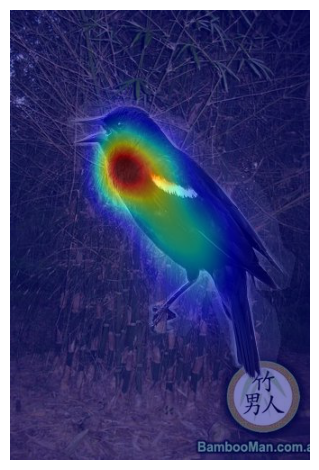

In [ ]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(imag), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()